<a href="https://colab.research.google.com/github/EdwinSarmiento/Clase_IA/blob/main/Enfermedades_cardiacas_Edwin.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Clasificador de Enfermedad Cardíaca — Proyecto de punta a punta (Colab)

**Curso:** Data Science for Health  
**Objetivo:** Construir un modelo de *clasificación* para detectar presencia de enfermedad cardíaca a partir de datos clínicos (dataset UCI).  
**Entregable:** Un único Notebook con código, salidas (tablas y gráficos) y conclusiones.

---



## Librerías y configuración

> Esta celda importa las librerías necesarias. Colab ya trae la mayoría instaladas.


In [1]:

# Librerías base
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocesamiento y modelado
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression

# Métricas
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay


## Carga del dataset y EDA breve

El dataset proviene del repositorio UCI y puede incluir variables categóricas (por ejemplo: `sex`, `cp`, `restecg`, `slope`, `thal`) y continuas (`age`, `trestbps`, `chol`, `thalch`, `oldpeak`, `ca`).  
La variable objetivo típica en este CSV es `num` (0 = sano, >0 = presencia de enfermedad). Para convertirlo en problema binario crearemos `target = 1` si `num>0`, en otro caso `0`.

> **Nota:** Si ejecutas en Colab, sube el archivo `heart_disease_uci.csv` con el diálogo de subida, o colócalo en la misma carpeta del notebook.


In [2]:
# Cargar CSV en DataFrame
csv_path = 'heart_disease_uci.csv'
df = pd.read_csv(csv_path)
print('Shape:', df.shape)
display(df.head(3))
display(df.info())
display(df.describe(include='all'))


Shape: (920, 16)


,id,age,sex,dataset,cp,trestbps,chol,fbs,restecg,thalch,exang,oldpeak,slope,ca,thal,num
0,1,63,Male,Cleveland,typical angina,145.0,233.0,True,lv hypertrophy,150.0,False,2.3,downsloping,0.0,fixed defect,0
1,2,67,Male,Cleveland,asymptomatic,160.0,286.0,False,lv hypertrophy,108.0,True,1.5,flat,3.0,normal,2
2,3,67,Male,Cleveland,asymptomatic,120.0,229.0,False,lv hypertrophy,129.0,True,2.6,flat,2.0,reversable defect,1


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 920 entries, 0 to 919
Data columns (total 16 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   id        920 non-null    int64  
 1   age       920 non-null    int64  
 2   sex       920 non-null    object 
 3   dataset   920 non-null    object 
 4   cp        920 non-null    object 
 5   trestbps  861 non-null    float64
 6   chol      890 non-null    float64
 7   fbs       830 non-null    object 
 8   restecg   918 non-null    object 
 9   thalch    865 non-null    float64
 10  exang     865 non-null    object 
 11  oldpeak   858 non-null    float64
 12  slope     611 non-null    object 
 13  ca        309 non-null    float64
 14  thal      434 non-null    object 
 15  num       920 non-null    int64  
dtypes: float64(5), int64(3), object(8)
memory usage: 115.1+ KB


None

,id,age,sex,dataset,cp,trestbps,chol,fbs,restecg,thalch,exang,oldpeak,slope,ca,thal,num
count,920.000000,920.000000,920,920,920,861.000000,890.000000,830,918,865.000000,865,858.000000,611,309.000000,434,920.000000
unique,NaN,NaN,2,4,4,NaN,NaN,2,3,NaN,2,NaN,3,NaN,3,NaN
top,NaN,NaN,Male,Cleveland,asymptomatic,NaN,NaN,False,normal,NaN,False,NaN,flat,NaN,normal,NaN
freq,NaN,NaN,726,304,496,NaN,NaN,692,551,NaN,528,NaN,345,NaN,196,NaN
mean,460.500000,53.510870,NaN,NaN,NaN,132.132404,199.130337,NaN,NaN,137.545665,NaN,0.878788,NaN,0.676375,NaN,0.995652
std,265.725422,9.424685,NaN,NaN,NaN,19.066070,110.780810,NaN,NaN,25.926276,NaN,1.091226,NaN,0.935653,NaN,1.142693
min,1.000000,28.000000,NaN,NaN,NaN,0.000000,0.000000,NaN,NaN,60.000000,NaN,-2.600000,NaN,0.000000,NaN,0.000000
25%,230.750000,47.000000,NaN,NaN,NaN,120.000000,175.000000,NaN,NaN,120.000000,NaN,0.000000,NaN,0.000000,NaN,0.000000
50%,460.500000,54.000000,NaN,NaN,NaN,130.000000,223.000000,NaN,NaN,140.000000,NaN,0.500000,NaN,0.000000,NaN,1.000000
75%,690.250000,60.000000,NaN,NaN,NaN,140.000000,268.000000,NaN,NaN,157.000000,NaN,1.500000,NaN,1.000000,NaN,2.000000



### Variable objetivo (¿balanceado?)
En muchos CSV de UCI, la columna objetivo es `num` con valores 0..4. Usaremos un enfoque binario:

- `target = 1` si `num > 0` (algún grado de enfermedad)  
- `target = 0` si `num == 0` (sin enfermedad)

Luego graficamos su distribución.


Conteo por clase (0=sano, 1=enfermedad):
 target
0    411
1    509


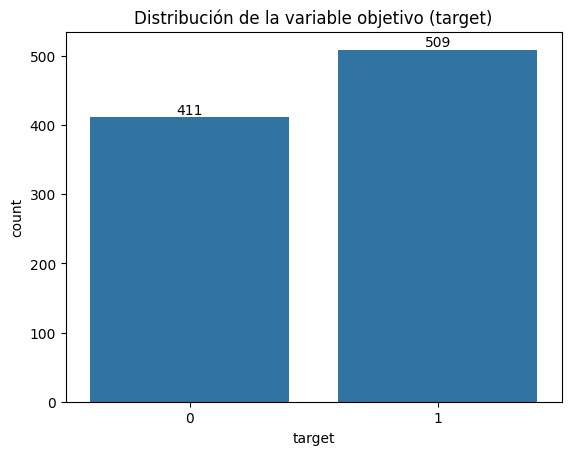

In [3]:

# Crear objetivo binario desde 'num'
if 'num' not in df.columns:
    raise ValueError("No se encontró la columna 'num' esperada en el CSV.")
df['target'] = (df['num'] > 0).astype(int)

# Conteo y distribución
target_counts = df['target'].value_counts().sort_index()
print('Conteo por clase (0=sano, 1=enfermedad):\n', target_counts.to_string())

# Gráfico con seaborn
ax = sns.countplot(x='target', data=df)
ax.bar_label(ax.containers[0])
plt.title('Distribución de la variable objetivo (target)')
plt.show()




## Limpieza y preprocesamiento

1. **Valores nulos:** se imputan.
   - Numéricas: mediana (`SimpleImputer(strategy='median')`).
   - Categóricas: moda (`SimpleImputer(strategy='most_frequent')`).

2. **Separación X / y:** quitamos identificadores innecesarios (p. ej. `id`) y columnas originales no deseadas (p. ej. `num`).

3. **Codificación & escalado:** usamos un `ColumnTransformer` con:
   - Pipeline numérico: *imputación + StandardScaler*.
   - Pipeline categórico: *imputación + OneHotEncoder*.

> Esto permitirá entrenar una **Regresión Logística**, que requiere variables numéricas.


In [4]:

# Opcional: quitar columnas no predictivas
cols_to_drop = [c for c in ['id', 'num'] if c in df.columns]
df = df.drop(columns=cols_to_drop)

# Separar X e y
if 'target' not in df.columns:
    raise ValueError("No se encontró la columna 'target'. Asegúrate de haberla creado.")
X = df.drop(columns=['target'])
y = df['target']

# Identificar tipos de variables
cat_cols = X.select_dtypes(include=['object', 'bool']).columns.tolist()
num_cols = [c for c in X.columns if c not in cat_cols]

print("Categóricas:", cat_cols)
print("Numéricas:", num_cols)

# Definir transformaciones
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, num_cols),
        ('cat', categorical_transformer, cat_cols)
    ]
)


Categóricas: ['sex', 'dataset', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'thal']
Numéricas: ['age', 'trestbps', 'chol', 'thalch', 'oldpeak', 'ca']



## División de datos (train/test) y escalado

- 80% entrenamiento y 20% prueba (`train_test_split`) con `stratify=y` para mantener la proporción de clases.
- El **escalado (StandardScaler)** se ajusta **solo con los datos de entrenamiento** gracias al pipeline.


In [5]:

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42, stratify=y
)

print('Shapes -> X_train:', X_train.shape, '| X_test:', X_test.shape)


Shapes -> X_train: (736, 14) | X_test: (184, 14)



## Entrenamiento del modelo (Regresión Logística)


In [6]:

# Definir pipeline completo: preprocesamiento + modelo
clf = Pipeline(steps=[
    ('preprocess', preprocessor),
    ('model', LogisticRegression(max_iter=200, solver='liblinear'))
])

# Entrenar
clf.fit(X_train, y_train)
print("Modelo entrenado.")


Modelo entrenado.



## Predicción y evaluación

Métricas solicitadas:
- **Exactitud (Accuracy)**
- **Matriz de confusión**


Exactitud (Accuracy): 0.837


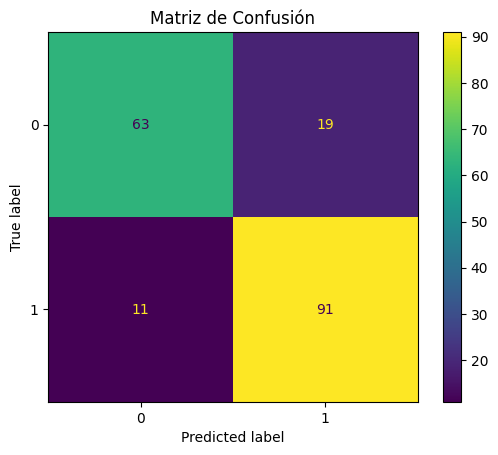

In [7]:

# Predicción
y_pred = clf.predict(X_test)

# Exactitud
acc = accuracy_score(y_test, y_pred)
print(f"Exactitud (Accuracy): {acc:.3f}")

# Matriz de confusión
cm = confusion_matrix(y_test, y_pred, labels=[0,1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1])
disp.plot(values_format='d')
plt.title('Matriz de Confusión')
plt.show()


_Notebook generado automáticamente el 2025-09-08 15:32:15_